### Load Data From Parquet

In [1]:
import pandas as pd
import collections

Market = collections.namedtuple('Market', 'candle_data market_index sec_index')

market_metadata = {
    600: Market(candle_data='historical_pr_data_600_sec.parquet',
                market_index='S_and_P_600_index.parquet',
                sec_index='sector_index_1000.parquet'),
    400: Market(candle_data='historical_pr_data_400_sec.parquet',
                market_index='S_and_P_400_index.parquet',
                sec_index='sector_index_400.parquet'),
    500: Market(candle_data='historical_pr_data_sec.parquet',
                market_index='S_and_P_index.parquet',
                sec_index='sector_index.parquet')
}

candle_dfs = {
    x: pd.read_parquet(market_metadata[x].candle_data)
    for x in market_metadata
}

In [2]:
df_norm = pd.concat((candle_dfs[x] for x in candle_dfs), axis=0, ignore_index=True)

In [3]:
df_norm = df_norm.drop_duplicates(subset=['date', 'symbol']).sort_values(['symbol', 'date']).reset_index(drop=True)

In [28]:
sym_df = df_norm.loc[df_norm.symbol == 'DVN']

In [10]:
import plotly.graph_objects as go

In [51]:
sym_df.loc[:, 'mv_avg'] = sym_df.close_adj.ewm(span=14, adjust=False).mean().ewm(span=14, adjust=False).mean()
sym_df.loc[:, 'prev_mv_avg'] = sym_df.mv_avg.shift(1)
sym_df.loc[:, 'next_mv_avg'] = sym_df.mv_avg.shift(-1)
sym_df.loc[:, 'maxima'] = 0
sym_df.loc[:, 'minima'] = 0
tolerance = .0001
maxima_bool = (sym_df.mv_avg > sym_df.prev_mv_avg )
maxima_bool &= (sym_df.mv_avg > sym_df.next_mv_avg)
minima_bool = (sym_df.mv_avg < sym_df.prev_mv_avg)
minima_bool &= (sym_df.mv_avg < sym_df.next_mv_avg)
sym_df.loc[maxima_bool, 'maxima'] = 1
sym_df.loc[minima_bool, 'minima'] = 1

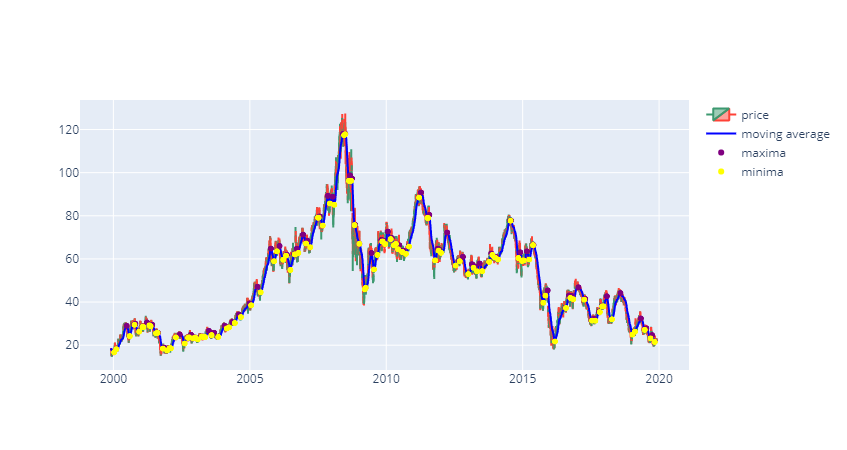

In [53]:
fig = go.Figure()

fig.add_trace(
    go.Candlestick(open=sym_df.open_adj, high=sym_df.high_adj, low=sym_df.low_adj,
                       close=sym_df.close_adj, x=sym_df.date, name='price'),
)

fig.add_trace(
    go.Scattergl(
        x=sym_df.date, y=sym_df.mv_avg, name='moving average', line=dict(color='blue')
    )
)

maxima = sym_df.loc[sym_df.maxima == 1]
minima = sym_df.loc[sym_df.minima == 1]

fig.add_trace(
    go.Scattergl(
        x=maxima.date, y=maxima.mv_avg, name='maxima', mode='markers', marker=dict(color='purple')
    )
)
fig.add_trace(
    go.Scattergl(
        x=minima.date, y=minima.mv_avg, name='minima', mode='markers', marker=dict(color='yellow')
    )
)

fig.update_layout(xaxis_rangeslider_visible=False)
fig

In [ ]:
import ta

def get_indicators(sym_df, rsi_period=7, roc_period=60, ma_period=200):
    rsi = ta.momentum.RSIIndicator(close=sym_df.close_adj, n=rsi_period).rsi()
    sym_df.loc[:, 'rsi'] = rsi
    sym_df.loc[:, 'roc'] = ta.momentum.ROCIndicator(sym_df.close_adj, n=roc_period).roc()
    sym_df.loc[:, 'mv_avg'] = sym_df.set_index(
        'date'
    ).close_adj.rolling('%dd' % ma_period, min_periods=1).mean().values
    return sym_df

In [ ]:
df_ind = df_norm.reset_index(drop=True).groupby('symbol').apply(get_indicators).reset_index(drop=True)

In [ ]:
bool_index = df_ind.regime_roc.notnull() & df_ind.sector_roc.isnull()
df_ind.loc[bool_index, 'sector_roc'] = df_ind.loc[bool_index, 'regime_roc']

In [ ]:
def get_entrances(df,
                  rsi_oversold=30,
                  roc_change=0,
                  regime_roc_change=0):
    df.loc[:, 'last_rsi'] = df.rsi.shift(1)
    df.loc[:, 'rsi_oversold_enter'] = 0
    df.loc[:, 'rsi_roc'] = df.rsi - df.last_rsi
    df.loc[:, 'last_rsi_roc'] = df.rsi_roc.shift(1)
    bool_index = (df.rsi <= rsi_oversold)
    bool_index &= (df.rsi_roc > df.last_rsi_roc)
    bool_index &= (df.roc > roc_change)
    bool_index &= (df.close_adj > df.mv_avg)
    #bool_index &= (df.regime_roc > regime_roc_change)
    bool_index &= (df.regime_close > df.regime_ma)
    #bool_index &= (df.sector_roc > regime_roc_change)
    bool_index &= (df.sector_close > df.sector_ma)
    df.loc[bool_index, 'rsi_oversold_enter'] = 1
    enter_cols = ['rsi_oversold_enter']
    df.loc[:, 'entrances'] = df[enter_cols].sum(axis=1).clip(upper=1)
    return df

In [ ]:
def get_exits(df, rsi_overbought=70):
    df.loc[:, 'rsi_overbought_exit'] = 0
    bool_index = df.rsi >= rsi_overbought
    df.loc[bool_index, 'rsi_overbought_exit'] = 1
    exit_cols = ['rsi_overbought_exit']
    df.loc[:, 'exits'] = df[exit_cols].sum(axis=1).clip(upper=1)
    return df

In [ ]:
df_enter_exit = df_ind.groupby('symbol').apply(lambda x: get_entrances(get_exits(x), roc_change=10, regime_roc_change=0))

In [ ]:
from numba import jit
import numpy as np

def backtest_seq(df, stop_thresh=0.1, run_length=30, inv_price=10000,
                 prof_avg_offset=30 * 6, ewm_prof_offset=30 * 6):
    df.loc[:, 'enter_exit_sig'] = df.entrances - df.exits
    df.loc[:, 'next_open'] = df.open_adj.shift(-1)
    profit, actual_enter_exit, shares_arr = backtest_numba(
        df.enter_exit_sig.values, df.close_adj.values,
        df.next_open.values, stop_thresh, run_length,
        inv_price
    )
    df.loc[:, 'profit'] = profit
    df.loc[:, 'cum_profit'] = df.profit.fillna(0).cumsum()
    df.loc[:, 'purch_shares'] = shares_arr
    df.loc[:, 'norm_profit'] = profit / (df.next_open * shares_arr)
    df.loc[df.profit == 0, 'norm_profit'] = np.nan
    df.loc[:, 'avg_profit'] = df.norm_profit.rolling(prof_avg_offset, min_periods=1).mean()
    df.loc[:, 'avg_profit_std'] = df.norm_profit.rolling(prof_avg_offset, min_periods=1).std()
    df.loc[:, 'eavg_profit'] = df.avg_profit.ewm(ewm_prof_offset, ignore_na=True).mean()
    df.loc[:, 'avg_profit'] = df.avg_profit.fillna(0)
    df.loc[:, 'actual_enter_exit'] = actual_enter_exit
    df.loc[:, 'actual_enter'] = 0
    df.loc[:, 'actual_exit'] = 0
    df.loc[df.actual_enter_exit == 1, 'actual_enter'] = 1
    df.loc[df.actual_enter_exit == -1, 'actual_exit'] = 1
    df.loc[:, 'trade_count'] = df.actual_enter_exit.rolling(prof_avg_offset).sum()
    return df
    

@jit(nopython=True)
def backtest_numba(enter_exit, close_price, open_price, stop_thresh,
                   run_length, inv_price):
    in_trade = False
    n = len(enter_exit)
    actual_enter_exit = np.zeros(n)
    shares_arr = np.zeros(n)
    profit = np.zeros(n)
    equity = np.zeros(n)
    start_price = 0.0
    top_price = start_price
    shares = 0
    for index in range(0, n):
        signal = enter_exit[index]
        if in_trade and close_price[index] > top_price:
            top_price = close_price[index]
        if not in_trade and signal == 1:
            enter_price = open_price[index]
            start_price = close_price[index]
            top_price = start_price
            shares = int(inv_price / start_price)
            shares_arr[index] = shares
            shares_cost = enter_price * shares
            actual_enter_exit[index] = 1
            in_trade = True
            enter_index = index
        elif in_trade and ((signal == -1) or ((index - enter_index) >= run_length)):
            profit[enter_index] = (open_price[index] - enter_price) * shares
            actual_enter_exit[index] = -1
            in_trade = False
        elif in_trade and ((top_price - close_price[index]) / top_price) >= stop_thresh:
            profit[enter_index] = (open_price[index] - enter_price) * shares
            actual_enter_exit[index] = -1
            in_trade = False
        elif index == (n - 1) and in_trade:
            profit[enter_index] = (open_price[index] - enter_price) * shares
            actual_enter_exit[index] = -1
            in_trade = False
    return profit, actual_enter_exit, shares_arr

In [ ]:
df_profits1 = df_enter_exit.groupby('symbol').apply(lambda x: backtest_seq(x, stop_thresh=1.0, inv_price=10000, run_length=100))

In [ ]:
import numpy as np

def get_profit_metrics(df_profits):
    wins_losses = {}
    col_name = 'profit'
    win_index = df_profits[col_name] > 0
    loss_index = df_profits[col_name] < 0
    mean_win = df_profits.loc[win_index, col_name].mean()
    mean_loss = df_profits.loc[loss_index, col_name].mean()
    mean_norm_profit_win = df_profits.loc[win_index, 'norm_profit'].mean()
    mean_norm_profit_loss = df_profits.loc[loss_index, 'norm_profit'].mean()
    mean_norm_profit = df_profits.norm_profit.mean()
    sum_win = df_profits.loc[win_index, col_name].sum()
    sum_loss = df_profits.loc[loss_index, col_name].sum()
    
    wins_losses[col_name] = [win_index.sum(), loss_index.sum(), win_index.sum() + loss_index.sum(),
                             mean_win, mean_loss,
                             mean_norm_profit_win, mean_norm_profit_loss,
                             mean_norm_profit,
                             sum_win, sum_loss
                            ]

    df_win_loss = pd.DataFrame(wins_losses, index=['wins', 'losses', 'ttl_trades', 'mean_win',
                                                   'mean_loss',
                                                   'mean_norm_profit_win', 'mean_norm_profit_loss',
                                                   'mean_norm_profit',
                                                   'ttl_win', 'ttl_loss']).transpose()
    df_win_loss.loc[:, 'win_loss_rate'] =  df_win_loss.wins / (df_win_loss.losses + df_win_loss.wins)
    df_win_loss.loc[:, 'win_loss_ratio'] = df_win_loss.mean_win / np.abs(df_win_loss.mean_loss)
    
    df_win_loss.loc[:, 'profit_factor'] = df_win_loss.ttl_win / np.abs(df_win_loss.ttl_loss)
    df_win_loss.loc[:, 'net_profit'] = df_win_loss.ttl_win + df_win_loss.ttl_loss
    return df_win_loss

In [ ]:
ttl_days = df_profits1['date'].unique().shape[0]
sig_days = df_profits1.loc[df_profits1.entrances == 1, 'date'].unique().shape[0]
sig_days / ttl_days

In [ ]:
df_win_loss = get_profit_metrics(df_profits1)

In [ ]:
df_profits1.loc[:, 'month'] = df_profits1['date'].dt.month

In [ ]:
df_win_loss_year = df_profits1.groupby('year').apply(get_profit_metrics)

In [ ]:
df_profits1.shape

In [ ]:
df_win_loss_year_month_sym = df_profits1.groupby(['symbol', 'year', 'month']).agg({'profit': 'sum'})
df_win_loss_year_month_sym = df_win_loss_year_month_sym.loc[df_win_loss_year_month_sym.profit != 0].reset_index()

In [ ]:
prof_2018 = df_win_loss_year_month_sym.loc[df_win_loss_year_month_sym.year == 2018]

In [ ]:
prof_2018.groupby('month').profit.sum()

In [ ]:
prof_2018.loc[prof_2018.month == 1].sort_values('profit', ascending=True)

In [ ]:
df_win_loss

In [ ]:
df_win_loss

In [ ]:
df_win_loss

In [ ]:
df_win_loss

In [ ]:
df_win_loss

In [ ]:
df_win_loss

In [ ]:
df_win_loss

In [ ]:
df_win_loss_year

In [ ]:
df_win_loss_year

In [ ]:
df_profits1.shape

In [ ]:
df_profits1.to_parquet('profits/RSIROC.parquet')

### Improvements 
* Look for price increase after reversion based indicators - V1
* Weight examples in XGBoost by Price. Look at training vs testing profit - V2
* Add Bollinger band based indicator - V3
* Add Regime Filter - V4
* Use Symbol Performance based filtering - V5
* Look at performance across Industry